In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from collections import OrderedDict

import jax.numpy as jnp
from jax import value_and_grad, jit, vmap, partial
from jax import random

import context 

from examples.logistic_regression.logistic_regression_model import gen_data_and_log_post

from samplers.sgld import sgld_jaxloop, sgld_kernel
from samplers.sghmc import sghmc_time_budget

from successive_halving.sh import Base_SGLD_SuccHalv_Time
from successive_halving.sh import run_SH_time_budget_keep_3, create_T_list_2params, create_T_list_sghmc
from ksd import imq_KSD
from util import wait_until_computed


# Logistic regression: Successive halving with KSD

_15th March 2021_


Keep last 3 chains. Run for `R` iterations and thin samples

#### Define model

In [2]:
from samplers.sgld import sgld, sgld_jaxloop, sgld_time_budget
from samplers.sgldcv import sgld_time_budget_CV

In [3]:

dim = 10
Ndata = 100000
key = random.PRNGKey(0) # same key as 'LR-evaluate_default_vs_KSD.ipynb'
theta_true, X, y_data, val_and_grad_log_post = gen_data_and_log_post(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
del X, y_data

def grad_lp_LR_fb(theta):
    return val_and_grad_log_post(theta, X_train, y_train)[1]

batch_grad_lp_LR_fb = jit(vmap(grad_lp_LR_fb))

generating data, with N=100000 and dim=10


In [4]:
# key = random.PRNGKey(0)
# Nsamples = 1000
# dt = 1e-5
# batch_size = int(X_train.shape[0]*0.1)



# samples, grads = sgld_jaxloop(key, val_and_grad_log_post, X_train, y_train, Nsamples, dt, batch_size, theta_true)

# wait_until_computed(samples)



In [4]:
class LR_succ_halving(Base_SGLD_SuccHalv_Time):
    "SH for sgld"
    
    def __init__(self, key, logdt, batch_size_ratio, thin_step=1):
        self.key = key
        self.logdt = logdt
        self.batch_size_ratio = batch_size_ratio
        self.x_0 = theta_true
        self.thin_step = thin_step
        super(LR_succ_halving, self).__init__(self.key, self.logdt, self.x_0)
        
    def _run_sampler(self, key, time_budget, x_0):
        dt = 10**self.logdt
        batch_size = int(self.batch_size_ratio*X_train.shape[0])
        sgld_samples, sgld_grads = sgld_time_budget(key, val_and_grad_log_post,
                                            X_train, y_train, time_budget, dt,
                                            batch_size, x_0)
        return sgld_samples[::self.thin_step], batch_grad_lp_LR_fb(sgld_samples[::self.thin_step])

class LR_CV_succ_halving(Base_SGLD_SuccHalv_Time):
    "SH for sgld-CV"
    
    def __init__(self, key, logdt, batch_size_ratio, thin_step=1):
        self.key = key
        self.logdt = logdt
        self.batch_size_ratio = batch_size_ratio
        self.x_0 = theta_true
        self.thin_step = thin_step
        super(LR_CV_succ_halving, self).__init__(self.key, self.logdt, self.x_0)
        
    def _run_sampler(self, key, time_budget, x_0):
        dt = 10**self.logdt
        batch_size = int(self.batch_size_ratio*X_train.shape[0])
        sgld_samples, sgld_grads = sgld_time_budget_CV(key, val_and_grad_log_post,
                                            X_train, y_train, time_budget, dt,
                                            batch_size, x_0, x_0)
        return sgld_samples[::self.thin_step], batch_grad_lp_LR_fb(sgld_samples[::self.thin_step])


### test the timed sampler

In [6]:
my_sgld = LR_succ_halving(random.PRNGKey(0), logdt=-4., batch_size_ratio=1, thin_step=10)
my_sgld.run(0.38)
print(my_sgld.len_samples)

25


## SH-KSD for sgld

Setup:     
- n = 50 
- R = 5 (ie: r= 0.385)
- eta = 3
- thin = 10
- key = random.PRNGKey(11)

Optimal:
- log-dt: 
- batch_size_ratio: 0.385662
- KSD: 13.58
- Number of samples: 1220
- Running time: 80seconds

In [5]:

R = 4
n = 90 # number of step sizes to try at first
r = R/40
thin_step = 10
eta = 3 # cut trials by 3 every time

print(f"r={r:.3f}")
key = random.PRNGKey(11)


sampler_dict_sgld = run_SH_time_budget_keep_3(key, r, n ,eta, thin_step, 
                                          LR_succ_halving, create_T_list_2params, X_train.shape[0])


r=0.100
Number of iterations: 4
Total budget: around 36 sec
=====

Iteration 0: 90 configurations with 0.100 seconds each
Combinations: [(-6.7614675, 0.0012328465), (-4.8720913, 0.35111916), (-4.196574, 0.0061359066), (-6.514867, 0.023101298), (-2.3158832, 0.0011497568), (-5.3547263, 0.006579331), (-4.380795, 0.0013219408), (-6.0954447, 0.107226714), (-6.086427, 0.0020092328), (-4.238162, 0.7054802), (-5.136458, 0.023101298), (-5.20208, 0.0061359066), (-4.3048887, 0.011497568), (-2.4910178, 0.004328762), (-2.3652296, 0.06579333), (-4.7542963, 0.49770236), (-4.9127307, 0.15199111), (-4.9345994, 0.07564633), (-5.8195796, 0.0018738173), (-5.489498, 0.35111916), (-4.2208314, 0.7054802), (-2.0716438, 0.49770236), (-3.830347, 0.046415884), (-6.642359, 0.015199109), (-6.5979686, 0.0026560882), (-3.601017, 0.09326034), (-2.4829845, 0.0057223677), (-2.0622888, 0.003274549), (-5.312859, 0.0028480361), (-6.6899705, 0.00811131), (-6.5973353, 0.020092327), (-3.300809, 0.16297507), (-3.6415071, 0.12

In [10]:
# key = 9
for k,v in sampler_dict_sgld.items():
    print(k, v.len_samples*10, v.KSD)

(-4.511118, 0.053366996) 15390 13.574863
(-4.799613, 0.040370174) 17870 14.850996
(-3.9642854, 0.07054803) 12820 16.92991


In [12]:
# key = 10
for k,v in sampler_dict_sgld.items():
    print(k, v.len_samples*10, v.KSD)

(-4.7738333, 0.035111915) 22680 11.919692
(-5.031511, 0.061359067) 13700 16.949902
(-4.1827707, 0.24770762) 5990 17.905048


In [14]:
# key = 11
for k,v in sampler_dict_sgld.items():
    print(k, v.len_samples*10, v.KSD)

(-4.2600718, 0.20092331) 6570 7.1215034
(-3.866678, 0.21544346) 6550 10.553577
(-4.0341845, 0.18738173) 7110 10.580689


### `R=1`

In [19]:
R = 1
n = 90 # number of step sizes to try at first
r = R/40
thin_step = 10
eta = 3 # cut trials by 3 every time

print(f"r={r:.3f}")
key = random.PRNGKey(9)


sampler_dict_sgld = run_SH_time_budget_keep_3(key, r, n ,eta, thin_step, 
                                          LR_succ_halving, create_T_list_2params, X_train.shape[0])


r=0.025
Number of iterations: 4
Total budget: around 9 sec
=====

Iteration 0: 90 configurations with 0.025 seconds each
Combinations: [(-3.4433675, 0.0040370165), (-4.4231825, 0.006579331), (-3.9642854, 0.07054803), (-2.8671837, 0.0012328465), (-6.2057047, 0.15199111), (-4.8681126, 0.46415886), (-2.6503396, 0.4328761), (-3.8863468, 0.30538556), (-4.720053, 0.23101297), (-3.3859363, 0.001629751), (-6.7969246, 0.07564633), (-6.2979455, 0.030538555), (-5.5268173, 0.003274549), (-3.9103491, 0.7054802), (-6.337294, 0.09326034), (-6.772856, 0.03274549), (-6.7959814, 0.14174742), (-6.5345078, 0.09326034), (-2.363896, 0.004977024), (-3.0675173, 0.20092331), (-2.729498, 0.75646335), (-5.003339, 0.16297507), (-6.271402, 0.1), (-5.465701, 0.01629751), (-5.5203934, 0.009326034), (-2.6838698, 0.00811131), (-4.7055426, 0.16297507), (-4.3265266, 0.65793324), (-2.812302, 0.01), (-2.6232338, 0.0075646355), (-4.6651335, 0.28480357), (-4.511118, 0.053366996), (-3.5245562, 0.7054802), (-2.3279161, 0.3511

In [20]:
# key=9, R=1
for k,v in sampler_dict_sgld.items():
    print(k, v.len_samples*10, v.KSD)

(-3.9460015, 0.5722368) 890 17.049875
(-3.8863468, 0.30538556) 1310 26.34693
(-4.3265266, 0.65793324) 810 28.074753


In [18]:
# key=10, R=1
for k,v in sampler_dict_sgld.items():
    print(k, v.len_samples*10, v.KSD)

(-4.7738333, 0.035111915) 5700 21.386074
(-4.315283, 0.020092327) 5310 23.503254
(-4.1827707, 0.24770762) 1480 35.39482


In [16]:
# key=11, R=1
for k,v in sampler_dict_sgld.items():
    print(k, v.len_samples*10, v.KSD)

(-5.104823, 0.037649363) 3820 14.916181
(-4.7591095, 0.03274549) 5140 15.266425
(-3.962039, 0.1) 2270 26.477127


In [63]:
n = 250

idx = 1

print(f"Iteration {idx}: n={n}")
while n > 3:
    idx += 1
    n = int(n/3)
    print(f"Iteration {idx}: n={n}")


Iteration 1: n=250
Iteration 2: n=83
Iteration 3: n=27
Iteration 4: n=9
Iteration 5: n=3


## SGLD with control variates

Text(0, 0.5, 'KSD')

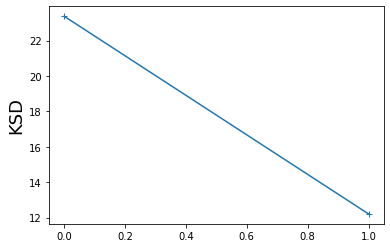

In [9]:
my_sgld = LR_CV_succ_halving(random.PRNGKey(0), logdt=-4., batch_size_ratio=0.1, thin_step=1)

num_l = 2

ksd_list = []


for i in range(num_l):
    my_sgld.run(0.4)
    ksd_list.append(my_sgld.get_ksd())

plt.plot(ksd_list, marker="+")
plt.ylabel("KSD", size=18)

In [65]:
my_sampler = LR_CV_succ_halving(random.PRNGKey(8), logdt=-3.50, batch_size_ratio=0.0071, thin_step=10)

In [66]:
my_sampler.run(5)

### `R=5`

In [8]:
R = 5   
thin_step = 10
r = R/40
n = 90
eta = 3

key = random.PRNGKey(9)

sampler_dict_sgldCV = run_SH_time_budget_keep_3(key, r, n ,eta, thin_step, 
                                          LR_CV_succ_halving, create_T_list_2params, X_train.shape[0])

Number of iterations: 4
Total budget: around 45 sec
=====

Iteration 0: 90 configurations with 0.125 seconds each
Combinations: [(-5.306595, 0.0021544343), (-2.8578467, 0.026560875), (-2.813631, 0.24770762), (-6.8268127, 0.07564633), (-2.7456803, 0.008697491), (-3.20741, 0.003274549), (-6.9501367, 0.014174741), (-6.618705, 0.014174741), (-5.5251026, 0.006579331), (-6.099063, 0.024770763), (-5.8108654, 0.37649357), (-5.69029, 0.020092327), (-4.58438, 0.0012328465), (-2.2129579, 0.002310129), (-5.3010254, 0.053366996), (-5.2359133, 0.23101297), (-4.33978, 0.107226714), (-3.932627, 0.75646335), (-4.480337, 0.01629751), (-6.3276334, 0.017475285), (-2.5662603, 0.18738173), (-4.9962387, 0.12328467), (-4.595799, 0.020092327), (-3.5173988, 0.869749), (-3.5182252, 0.23101297), (-5.5540276, 0.0018738173), (-4.608241, 0.0075646355), (-6.8853774, 0.030538555), (-3.590908, 0.35111916), (-4.589405, 0.13219412), (-2.4927673, 0.1), (-2.3279972, 0.869749), (-2.776041, 0.024770763), (-5.193338, 0.013219

In [68]:
# key = 9, R=5
for k,v in sampler_dict_sgldCV.items():
    print(k, v.len_samples*10, v.KSD)

(-3.8062978, 0.01) 26510 5.0105863
(-3.798426, 0.0014174745) 24160 5.347859
(-3.991489, 0.0046415897) 24710 6.148113


In [70]:
# key = 10, R=5
for k,v in sampler_dict_sgldCV.items():
    print(k, v.len_samples*10, v.KSD)

(-3.9246058, 0.0057223677) 26560 4.9681315
(-3.914311, 0.008697491) 26960 5.4526114
(-3.9236398, 0.0035111913) 25180 5.524995


In [72]:
# key = 11, R=5
for k,v in sampler_dict_sgldCV.items():
    print(k, v.len_samples*10, v.KSD)

(-3.8863416, 0.0018738173) 23190 5.2568235
(-4.129985, 0.018738173) 24960 6.200722
(-3.7366982, 0.008697491) 26080 6.778356


#### `R=1`

In [77]:
R = 1
thin_step = 10
r = R/40
n = 90
eta = 3

key = random.PRNGKey(11)


sampler_dict_sgldCV = run_SH_time_budget_keep_3(key, r, n ,eta, thin_step, 
                                          LR_CV_succ_halving, create_T_list_2params, X_train.shape[0])

Number of iterations: 4
Total budget: around 9 sec
=====

Iteration 0: 90 configurations with 0.025 seconds each
Combinations: [(-6.691705, 0.040370174), (-5.333425, 0.035111915), (-4.2600718, 0.20092331), (-5.947973, 0.0011497568), (-2.564187, 0.01629751), (-3.6799986, 0.0014174745), (-2.169177, 0.0061359066), (-4.756286, 0.93260336), (-2.0947132, 0.46415886), (-5.253189, 0.24770762), (-2.7692327, 0.65793324), (-4.994371, 0.3274549), (-6.644969, 0.043287612), (-6.897544, 0.061359067), (-3.0132246, 0.011497568), (-5.4574037, 0.75646335), (-3.6857858, 0.0057223677), (-3.9267642, 0.37649357), (-6.0422287, 0.1), (-4.5916057, 0.001), (-4.597066, 0.09326034), (-3.866678, 0.21544346), (-6.729099, 0.0018738173), (-3.3585324, 0.49770236), (-6.271691, 0.030538555), (-5.619017, 0.0017475284), (-2.4047012, 0.0028480361), (-2.5443726, 0.0057223677), (-4.985343, 0.46415886), (-2.2587037, 0.7054802), (-5.500347, 0.20092331), (-2.1120667, 0.003274549), (-2.529851, 0.0075646355), (-5.104823, 0.0376493

In [15]:
R = 1
thin_step = 10
r = R/40
n = 90
eta = 3

key = random.PRNGKey(11)


sampler_dict_sgldCV = run_SH_time_budget_keep_3(key, r, n ,eta, thin_step, 
                                          LR_CV_succ_halving, create_T_list_2params, X_train.shape[0])

Number of iterations: 4
Total budget: around 9 sec
=====

Iteration 0: 90 configurations with 0.025 seconds each
Combinations: [(-6.7614675, 0.0012328465), (-4.8720913, 0.35111916), (-4.196574, 0.0061359066), (-6.514867, 0.023101298), (-2.3158832, 0.0011497568), (-5.3547263, 0.006579331), (-4.380795, 0.0013219408), (-6.0954447, 0.107226714), (-6.086427, 0.0020092328), (-4.238162, 0.7054802), (-5.136458, 0.023101298), (-5.20208, 0.0061359066), (-4.3048887, 0.011497568), (-2.4910178, 0.004328762), (-2.3652296, 0.06579333), (-4.7542963, 0.49770236), (-4.9127307, 0.15199111), (-4.9345994, 0.07564633), (-5.8195796, 0.0018738173), (-5.489498, 0.35111916), (-4.2208314, 0.7054802), (-2.0716438, 0.49770236), (-3.830347, 0.046415884), (-6.642359, 0.015199109), (-6.5979686, 0.0026560882), (-3.601017, 0.09326034), (-2.4829845, 0.0057223677), (-2.0622888, 0.003274549), (-5.312859, 0.0028480361), (-6.6899705, 0.00811131), (-6.5973353, 0.020092327), (-3.300809, 0.16297507), (-3.6415071, 0.12328467), 

In [74]:
# key = 9, R=1
for k,v in sampler_dict_sgldCV.items():
    print(k, v.len_samples*10, v.KSD)

(-3.991489, 0.0046415897) 4960 11.811738
(-3.8062978, 0.01) 5230 13.94952
(-3.8863468, 0.30538556) 1050 14.105402


In [76]:
# key=10, R=1
for k,v in sampler_dict_sgldCV.items():
    print(k, v.len_samples*10, v.KSD)

(-3.9246058, 0.0057223677) 5110 12.076752
(-3.9236398, 0.0035111913) 4770 12.17029
(-3.9197273, 0.002310129) 4690 15.65608


In [78]:
# key=11, R=1
for k,v in sampler_dict_sgldCV.items():
    print(k, v.len_samples*10, v.KSD)

(-3.6857858, 0.0057223677) 5300 7.9246235
(-3.8822062, 0.08697491) 2250 8.234667
(-3.52909, 0.04977024) 3420 8.929874


# SG-HMC: tune L as well as dt and b_s_r

(393, 10)


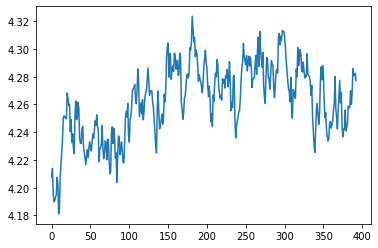

In [79]:
time_budget = 1
dt = 1e-6
batch_size = int(0.1*X_train.shape[0])
alpha = 0.01
L = 10
key = random.PRNGKey(0)


samples_hmc, grads_hmc = sghmc_time_budget(key, val_and_grad_log_post, X_train, y_train, time_budget, dt, batch_size, theta_true, alpha, L,)

print(samples_hmc.shape)

plt.plot(samples_hmc[:,0])

In [9]:
class LR_succ_halving_HMC_L(Base_SGLD_SuccHalv_Time):
    
    def __init__(self, key, logdt, batch_size_ratio, L, thin_step):
        self.key = key
        self.logdt = logdt
        self.batch_size_ratio = batch_size_ratio
        self.x_0 = theta_true
        self.L = L
        self.alpha = 0.01
        self.thin_step = thin_step
        super(LR_succ_halving_HMC_L, self).__init__(self.key, self.logdt, self.x_0)
        
    def _run_sampler(self, key, time_budget, x_0):
        dt = 10**self.logdt
        batch_size = int(self.batch_size_ratio*X_train.shape[0])
        hmc_samples, hmc_grads = sghmc_time_budget(key, val_and_grad_log_post, X_train, y_train, 
                                       time_budget, dt, batch_size, x_0, self.alpha, self.L,)
        
        return hmc_samples[::self.thin_step], batch_grad_lp_LR_fb(hmc_samples[::self.thin_step])

Text(0, 0.5, 'KSD')

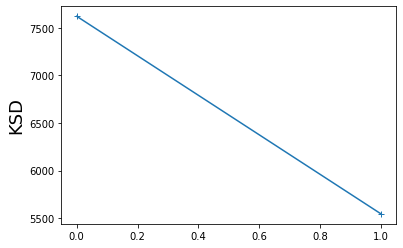

In [9]:

my_sgld = LR_succ_halving_HMC_L(random.PRNGKey(0), logdt=-4., batch_size_ratio=0.1, L=10, thin_step=10)

num_l = 2

ksd_list = []


for i in range(num_l):
    my_sgld.run(0.1)
    ksd_list.append(my_sgld.get_ksd())

plt.plot(ksd_list, marker="+")
plt.ylabel("KSD", size=18)

In [82]:
time_budget = 1
dt = 10**my_sgld.logdt
batch_size = int(my_sgld.batch_size_ratio*X_train.shape[0])
x_0 = theta_true


hmc_samples, hmc_grads = sghmc_time_budget(key, val_and_grad_log_post, X_train, y_train, 
                                   time_budget, dt, batch_size, x_0, my_sgld.alpha, my_sgld.L,)



In [ ]:
# imq_KSD(hmc_samples, batch_grad_lp_LR_fb(hmc_samples))

### R=10

In [10]:
R = 10
thin_step = 10
r = R/40 # number of samples per run
n = 120 # number of step sizes to try at first
eta = 3 # cut trials by 3 every time

key = random.PRNGKey(11)

sampler_dict_hmc = run_SH_time_budget_keep_3(key, r, n ,eta, thin_step, 
                              LR_succ_halving_HMC_L, create_T_list_sghmc, X_train.shape[0])

Number of iterations: 4
Total budget: around 120 sec
=====

Iteration 0: 120 configurations with 0.250 seconds each
Combinations: [(-3.760151, 0.18738173, 23), (-5.0625005, 0.23101297, 27), (-4.028365, 0.0132194115, 14), (-3.7762275, 0.002310129, 21), (-5.9251423, 0.28480357, 8), (-6.5402412, 0.17475285, 24), (-6.836138, 0.00811131, 17), (-2.1837783, 0.1, 2), (-4.585864, 0.017475285, 5), (-6.6855206, 0.06579333, 8), (-6.782314, 0.017475285, 16), (-4.4124866, 0.6135907, 6), (-4.5204964, 0.6135907, 19), (-5.336386, 0.057223674, 16), (-6.592788, 0.0057223677, 5), (-3.9680119, 0.21544346, 6), (-6.3121014, 0.6135907, 9), (-4.6410494, 0.0024770768, 19), (-5.1446037, 0.30538556, 28), (-6.842727, 0.0013219408, 8), (-6.613059, 0.28480357, 4), (-6.933839, 0.006579331, 13), (-4.914266, 0.00811131, 2), (-6.0952597, 0.001, 19), (-6.4663596, 0.0015199113, 27), (-2.6148663, 0.026560875, 3), (-2.5756478, 0.23101297, 15), (-4.4728875, 0.0061359066, 26), (-5.370265, 0.15199111, 12), (-4.1450233, 0.00533

In [92]:
# R=10, key = 9
for k,v in sampler_dict_hmc.items():
    print(k, v.len_samples*10, v.KSD)

(-6.6269836, 0.04520354, 24) 3920 7.634967
(-6.577629, 0.013738236, 14) 21130 7.92383
(-5.962383, 0.07278954, 15) 3380 9.100683


In [96]:
# R=10, key = 10
for k,v in sampler_dict_hmc.items():
    print(k, v.len_samples*10, v.KSD)

(-6.6124353, 0.013738236, 18) 18270 6.2574816
(-5.625224, 0.02212216, 5) 38450 7.067375
(-5.6487303, 0.017433286, 6) 38240 7.155253


In [98]:
# R=10, key = 11
for k,v in sampler_dict_hmc.items():
    print(k, v.len_samples*10, v.KSD)

(-6.9671035, 0.004175319, 22) 38660 6.7931266
(-6.1923623, 0.013738236, 18) 20520 9.388321
(-5.7051334, 0.057361532, 8) 7510 10.630312


### redo for `R=3`

In [103]:
R = 3
thin_step = 10
r = R/40 # number of samples per run
n = 120 # number of step sizes to try at first
eta = 3 # cut trials by 3 every time

key = random.PRNGKey(11)

# sampler_dict_hmc_3sec = run_SH_time_budget_L_keep_3(key, r, n ,eta, thin_step, LR_succ_halving_HMC_L, X_train.shape[0])

sampler_dict_hmc_3sec = run_SH_time_budget_keep_3(key, r, n ,eta, thin_step, 
                              LR_succ_halving_HMC_L, create_T_list_sghmc, X_train.shape[0])

Number of iterations: 4
Total budget: around 36 sec
=====

Iteration 0: 120 configurations with 0.075 seconds each
Combinations: [(-5.057761, 0.4893901, 20), (-2.3829331, 0.38566202, 1), (-2.8594408, 0.1487352, 15), (-4.7622423, 0.1487352, 28), (-2.9108453, 0.7880463, 7), (-2.0267525, 0.010826366, 9), (-6.199256, 0.0923671, 3), (-3.8633766, 0.7880463, 1), (-2.878265, 0.02212216, 7), (-2.0327086, 0.0012689614, 5), (-4.09151, 0.7880463, 20), (-2.3152962, 0.0012689614, 12), (-6.2518435, 0.0025929436, 19), (-5.3227167, 0.38566202, 12), (-6.1573687, 0.1887392, 6), (-4.951436, 0.4893901, 10), (-5.6378517, 1.0, 13), (-5.461047, 0.1887392, 21), (-2.663578, 0.117210224, 19), (-3.9102354, 0.1887392, 3), (-4.4285336, 0.00853168, 10), (-2.8707662, 0.1487352, 6), (-4.7717876, 0.0020433601, 29), (-2.4661674, 0.0923671, 11), (-3.5748346, 0.00853168, 11), (-2.6253376, 1.0, 20), (-2.482822, 0.010826366, 22), (-4.165347, 0.017433286, 28), (-2.9154549, 0.7880463, 0), (-3.120286, 0.4893901, 15), (-2.86988

In [100]:
# R=3, key=9
for k,v in sampler_dict_hmc_3sec.items():
    print(k, v.len_samples*10, v.KSD)

(-6.296073, 0.02212216, 11) 6190 7.714067
(-6.577629, 0.013738236, 14) 7660 11.165333
(-6.6269836, 0.04520354, 24) 1320 17.915895


In [102]:
# R=3, key=10
for k,v in sampler_dict_hmc_3sec.items():
    print(k, v.len_samples*10, v.KSD)

(-6.6124353, 0.013738236, 18) 5960 9.247051
(-5.6487303, 0.017433286, 6) 11590 12.620041
(-5.625224, 0.02212216, 5) 11290 13.855005


In [104]:
# R=3, key=11
for k,v in sampler_dict_hmc_3sec.items():
    print(k, v.len_samples*10, v.KSD)

(-6.9671035, 0.004175319, 22) 11090 14.912791
(-6.1923623, 0.013738236, 18) 6150 17.330124
(-5.7051334, 0.057361532, 8) 2480 25.257261
